# TA Review 2
*1/21/2025*

## FINM 37400 - 2025

### UChicago Financial Mathematics

* Burak Sekerci
* bsekerci@uchicago.edu

### Agenda
- Bond Prices and it's relationship with interest rates
    - Duration
    - Convexity

- Case study on 2008 Trading Opportunity

- FRNs
    - Key Takeaways
    - Fixed vs Floating



# Bond Prices and it's Relationship to Interest Rates

Why can't we estimte the sensitivity of bond prices to interest rates via linear regression? 
 - Because a bond's maturity changes constantly and it is not necessarily the same product that it was a day ago or a month ago. 
 - We also have many rates at hand and it is not apparent which rate to use when you would make a sensitivty analysis.
 - Bonds offer a mathematical relationship that has a clean answer when trying to find out their sensitivty to interest rates

Bond's price is a non linear function of rates:
 - Which means we can't really get a simple formula for it's sensitivity
 - However we can use the Taylor's approximation to get a good sense

![Screenshot 2025-01-19 at 4.15.26 PM.png](<attachment:Screenshot 2025-01-19 at 4.15.26 PM.png>)
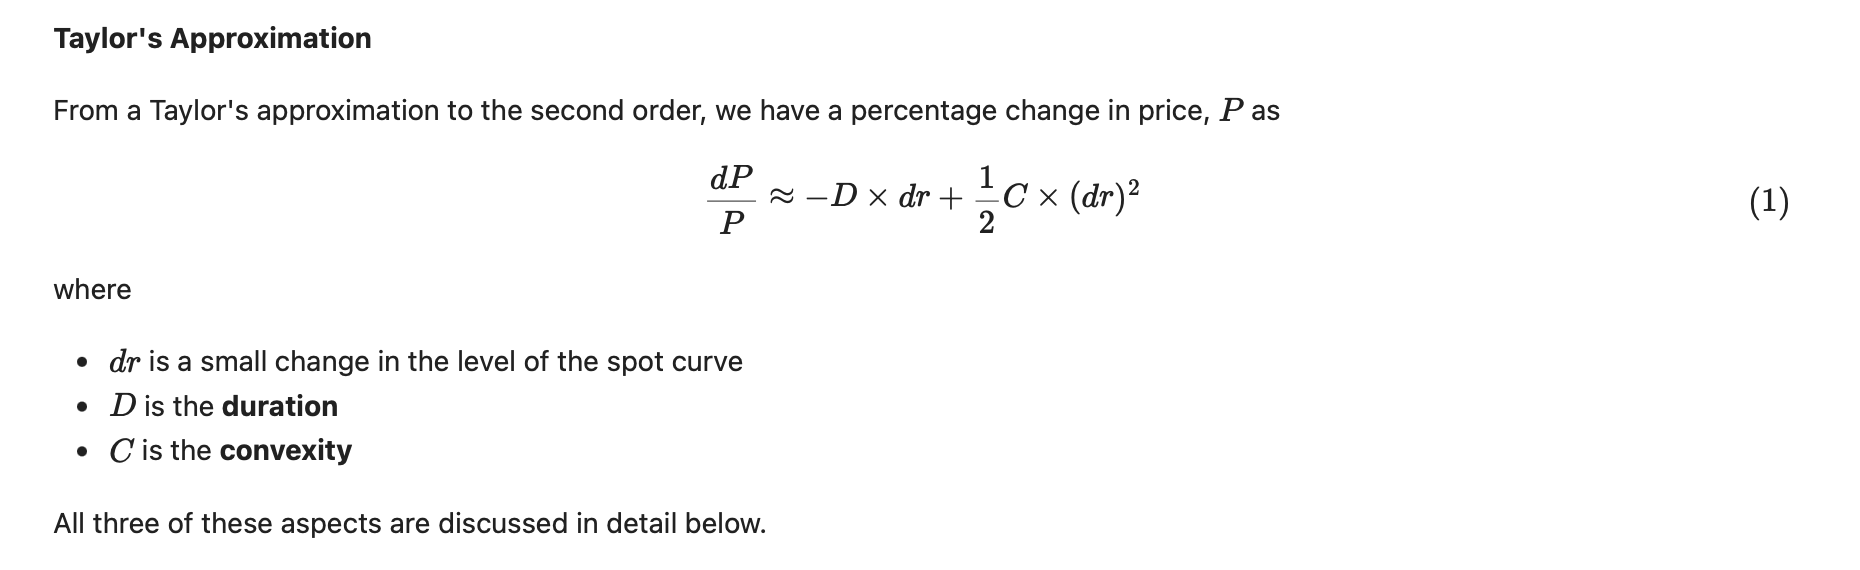

### Duration

- It refers to the sensitiity of a bond to the level of interest rates
- It reflects a parallel shift in all of the rates rather than a change in a rate at one maturity
- It is a percentage change in price of the bond
- The negative sign reflects the relationship as being inverse (dP/dr is nehative!)

![Screenshot 2025-01-19 at 4.20.07 PM.png](<attachment:Screenshot 2025-01-19 at 4.20.07 PM.png>)
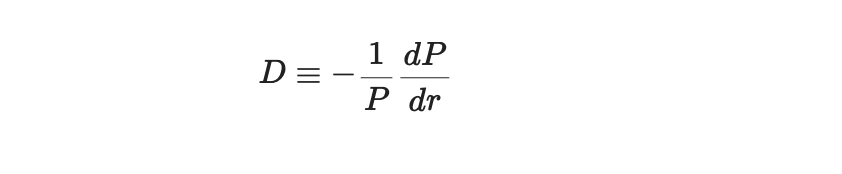

![Screenshot 2025-01-19 at 4.20.38 PM.png](<attachment:Screenshot 2025-01-19 at 4.20.38 PM.png>)
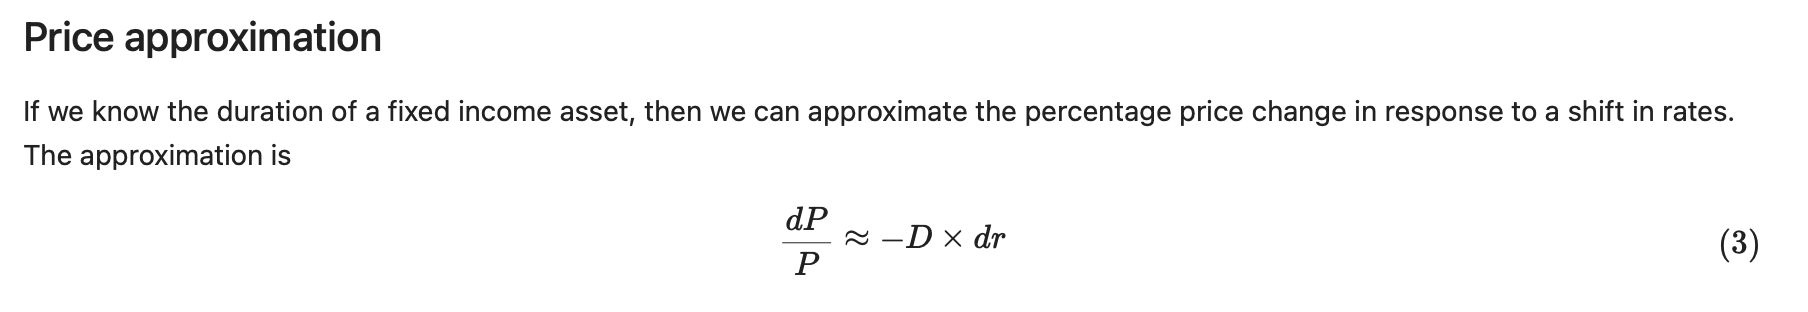

### Zero-coupon vs Coupon Bonds
- What is the duration of a zero-coupon bond?
 - Equal to its time to maturity
- What is the duration of a coupon bond? 
    - Weighted average of time to cashflow
    - Higher the coupon the lower the duration given time to cashflow is quicker

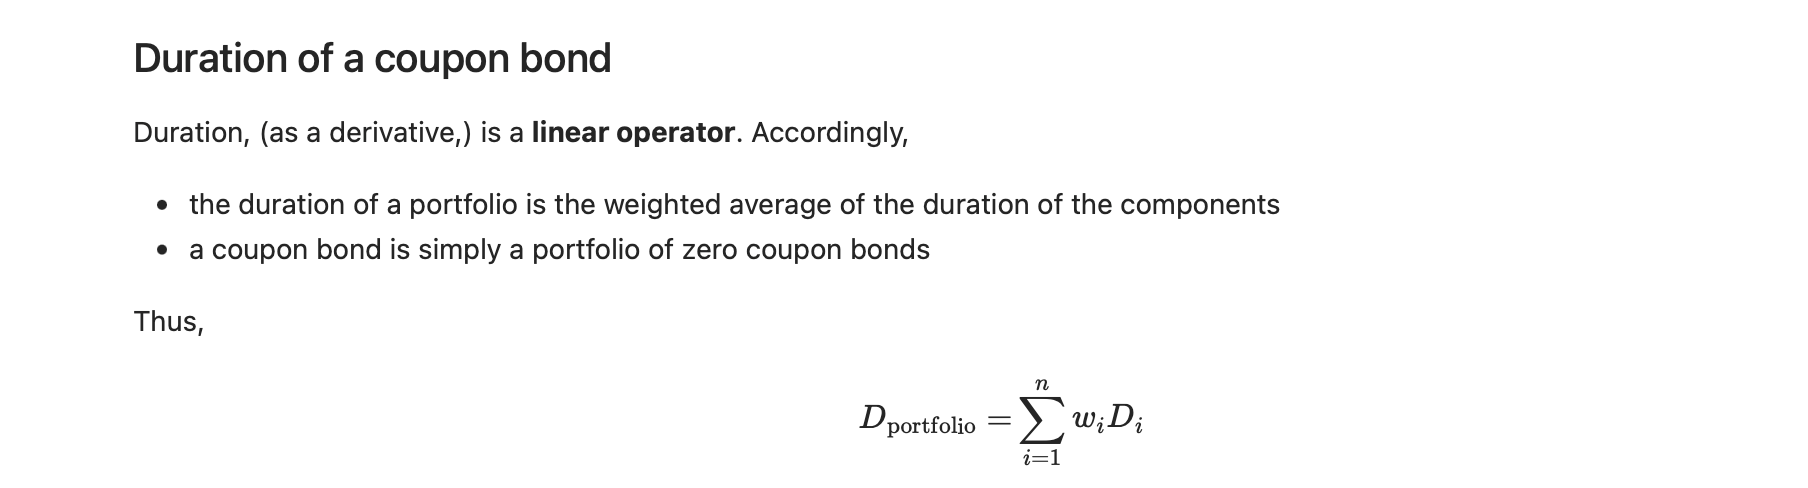

![Screenshot 2025-01-21 at 4.50.14 PM.png](<attachment:Screenshot 2025-01-21 at 4.50.14 PM.png>)
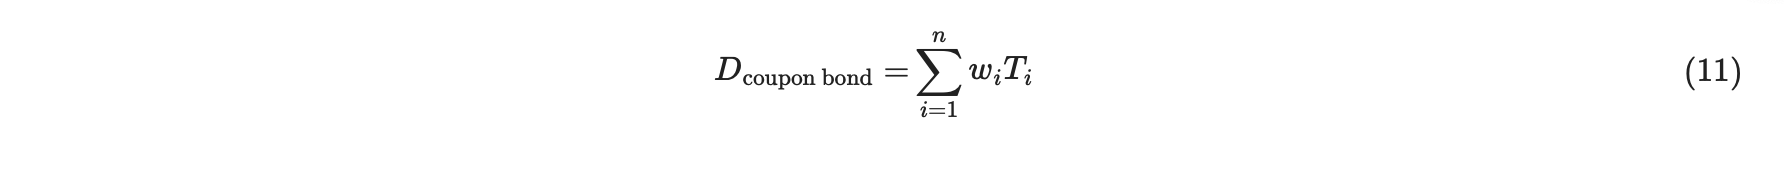

### Quick Numerical Example

In [1]:
import pandas as pd
import numpy as np
import datetime
import warnings
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)
import sys
sys.path.insert(0, '../cmds')
from treasury_cmds import *

In [10]:
	
QUOTE_DATE = '2024-05-31'
filepath_rawdata = f'../data/treasury_quotes_{QUOTE_DATE}.xlsx'
rawdata = pd.read_excel(filepath_rawdata,sheet_name='quotes')
column_mapping = {"quote date"    : "CALDT", 
                  "maturity date" : "TMATDT",
                  "bid"           : "TDBID",
                  "ask"           : "TDASK",
                  "accrued int"   : "TDACCINT",
                  "type"          : "ITYPE",
                  "cpn rate"      : "TCOUPRT",
                  "ytm"           : "TDYLD"}
rawdata.rename(columns=column_mapping,inplace=True)
rawdata.sort_values('TMATDT',inplace=True)
rawdata.set_index('KYTREASNO',inplace=True)

t_check = rawdata['CALDT'].values[0]
if rawdata['CALDT'].eq(t_check).all():
    t_current = t_check
else:
    warnings.warn('Quotes are from multiple dates.')
    t_current = None

In [12]:
MODEL = nelson_siegel

RESTRICT_YLD = True
RESTRICT_TIPS = True

RESTRICT_DTS_MATURING = False
RESTRICT_REDUNDANT = False

data = filter_treasuries(rawdata, t_date=t_current, filter_yld = RESTRICT_YLD, filter_tips = RESTRICT_TIPS, drop_duplicate_maturities=RESTRICT_REDUNDANT)

CF = filter_treasury_cashflows(calc_cashflows(data),filter_maturity_dates=RESTRICT_DTS_MATURING)

prices = rawdata['dirty price'][CF.index]

params = estimate_rate_curve(nelson_siegel,CF,t_current,prices)
if MODEL == nelson_siegel_extended:
    x0 = np.concatenate((params_NS,(1,1)))
    params = estimate_rate_curve(nelson_siegel_extended,CF,t_current,prices,x0=x0)

/Users/buraksekerci/Desktop/FixedIncome 2025/Week 2/../cmds/treasury_cmds.py:63: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_range(end=maturity_date, periods=np.ceil((maturity_date-quote_date).days/180), freq=pd.DateOffset(months=6))
/Users/buraksekerci/Desktop/FixedIncome 2025/Week 2/../cmds/treasury_cmds.py:136: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  CF.loc[i,coupon_dates] = quote_data.loc[i,'TCOUPRT']/2
/Users/buraksekerci/Desktop/FixedIncome 2025/Week 2/../cmds/treasury_cmds.py:63: FutureWarning: Non-integer 'periods' in pd.date_range, pd.timedelta_range, pd.period_range, and pd.interval_range are deprecated and will raise in a future version.
  temp = pd.date_ran

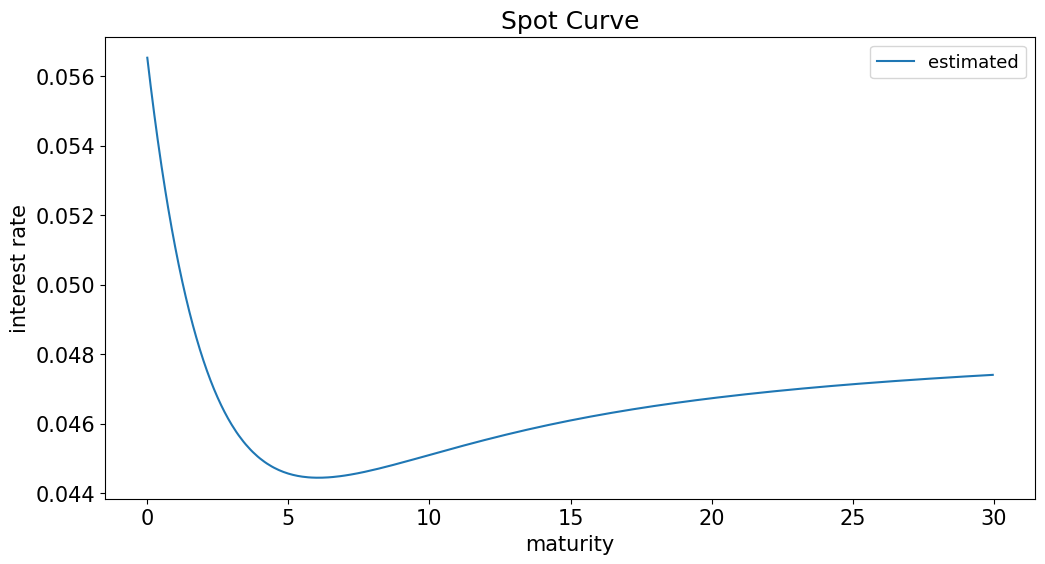

In [13]:
maturity_grid = get_maturity_delta(CF.columns,t_current)
curve = nelson_siegel(params,maturity_grid)

curves = pd.DataFrame(index = maturity_grid)
if MODEL == nelson_siegel_extended:
    curves['estimated']= nelson_siegel_extended(params,maturity_grid)
else:
    curves['estimated'] = nelson_siegel(params,maturity_grid)

curves.plot(xlabel='maturity',ylabel='interest rate',title='Spot Curve')
plt.show()

In [32]:
CF_prices = price_with_rate_model(params,CF,t_current,MODEL,price_coupons=True) ##Each discounted cashflow
model_prices = CF_prices.sum(axis=1) ###add them up for price

CF_wts = CF_prices.div(model_prices,axis=0) ##Weights of each cashflow in the price

CF_intervals = get_maturity_delta(CF.columns.to_series(),t_current) ##Time to each cashflow
model_duration = (CF_wts * CF_intervals).sum(axis=1) ##Weighted average time to maturity

display(CF_wts.iloc[-5:,-10:])


,2052-02-15,2052-05-15,2052-08-15,2052-11-15,2053-02-15,2053-05-15,2053-08-15,2053-11-15,2054-02-15,2054-05-15
KYTREASNO,,,,,,,,,,
208062,0.000000,0.005841,0.000000,0.005699,0.000000,0.312486,0.000000,0.000000,0.000000,0.000000
208107,0.006075,0.000000,0.005929,0.000000,0.005785,0.000000,0.279445,0.000000,0.000000,0.000000
208149,0.000000,0.006300,0.000000,0.006147,0.000000,0.006001,0.000000,0.252386,0.000000,0.000000
208178,0.006130,0.000000,0.005983,0.000000,0.005838,0.000000,0.005698,0.000000,0.267209,0.000000
208233,0.000000,0.006261,0.000000,0.006109,0.000000,0.005963,0.000000,0.005818,0.000000,0.251273


In [19]:
display(model_duration)

KYTREASNO
208166     0.010951
208141     0.016427
208179     0.030116
208072     0.035592
207730     0.041068
            ...    
208062    16.855305
208107    16.269391
208149    16.030306
208178    16.286616
208233    16.239340
Length: 393, dtype: float64

### Convexity

 - Duration is the first derivative of a price of a bond
 - Convexity is the second derivative
 - It represents the curvature of the change in the price. You can also say convexity describes the rate of change of a bond's duration with respect to changes in interest rates. 
 - Makes the approximation of a bond's price much more accurate when combined with duration
 - Convexity is always positive

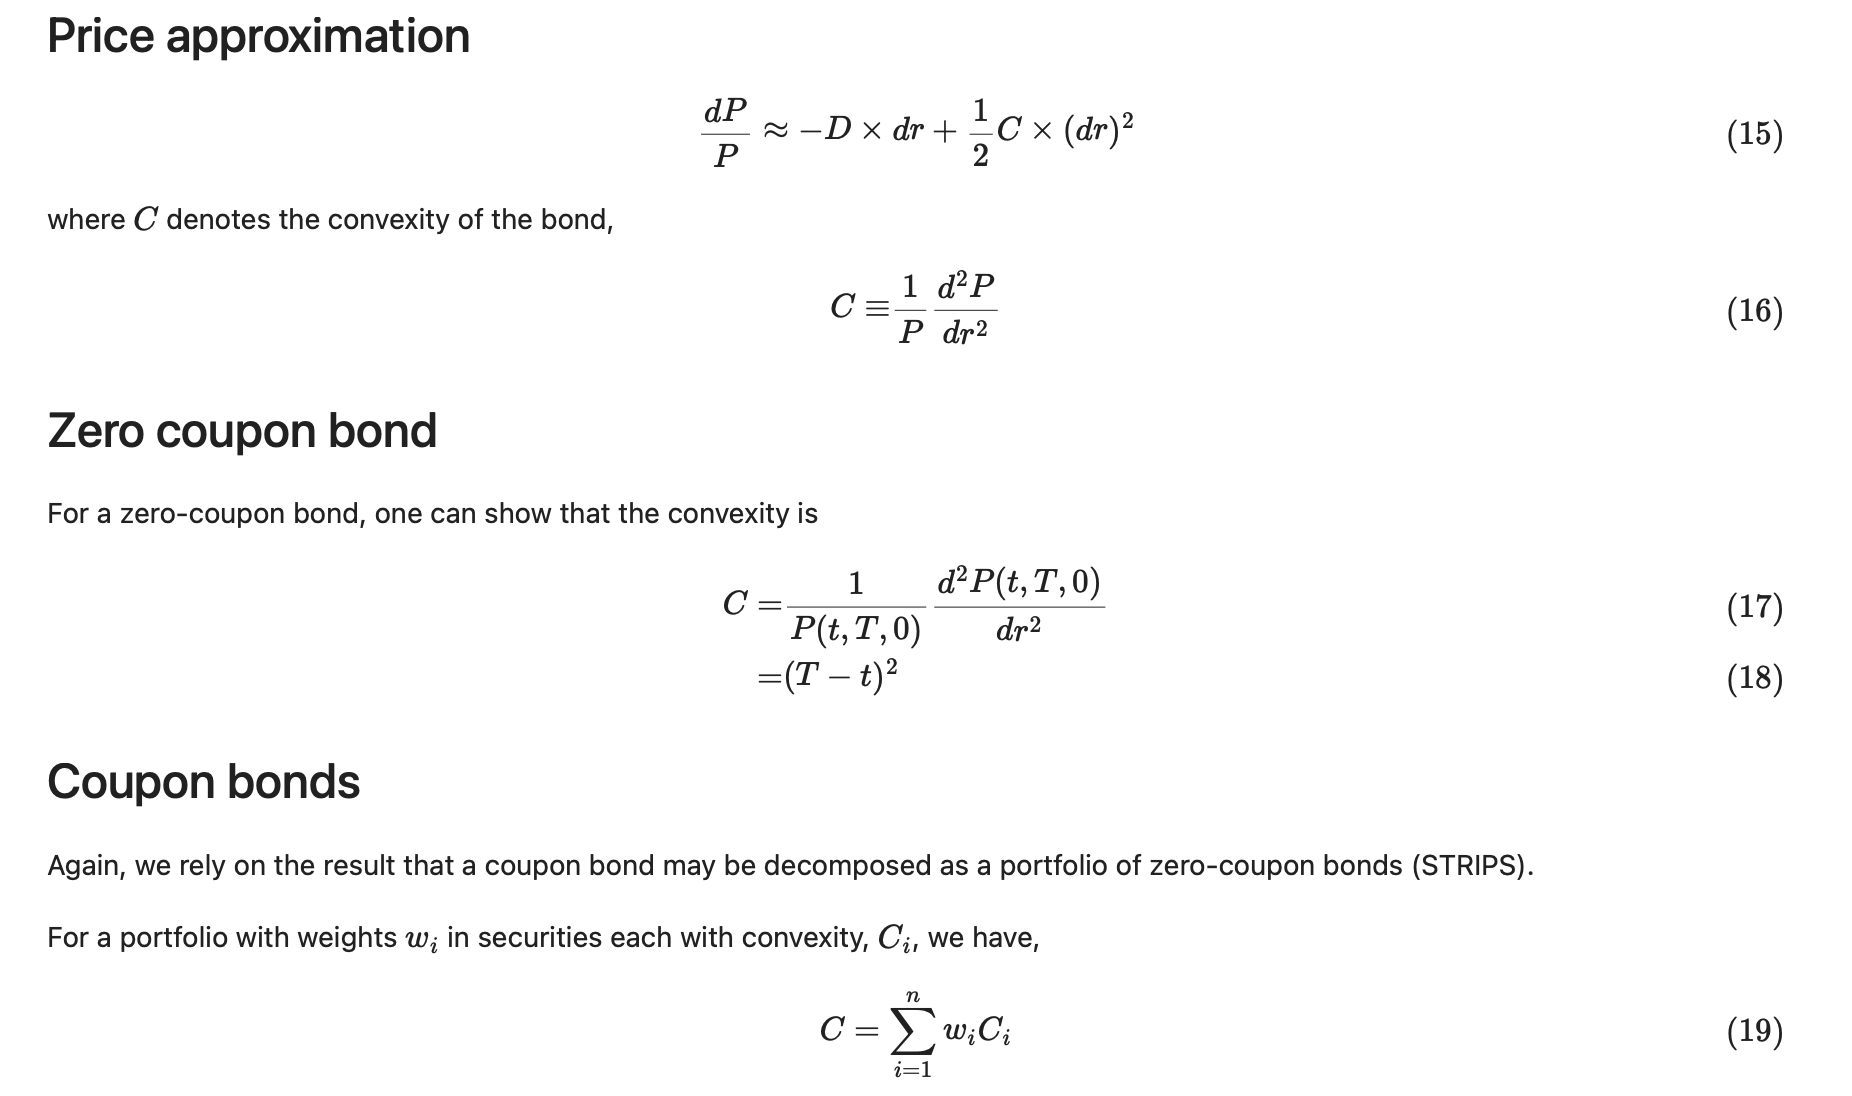

![Screenshot 2025-01-19 at 4.51.47 PM.png](<attachment:Screenshot 2025-01-19 at 4.51.47 PM.png>)
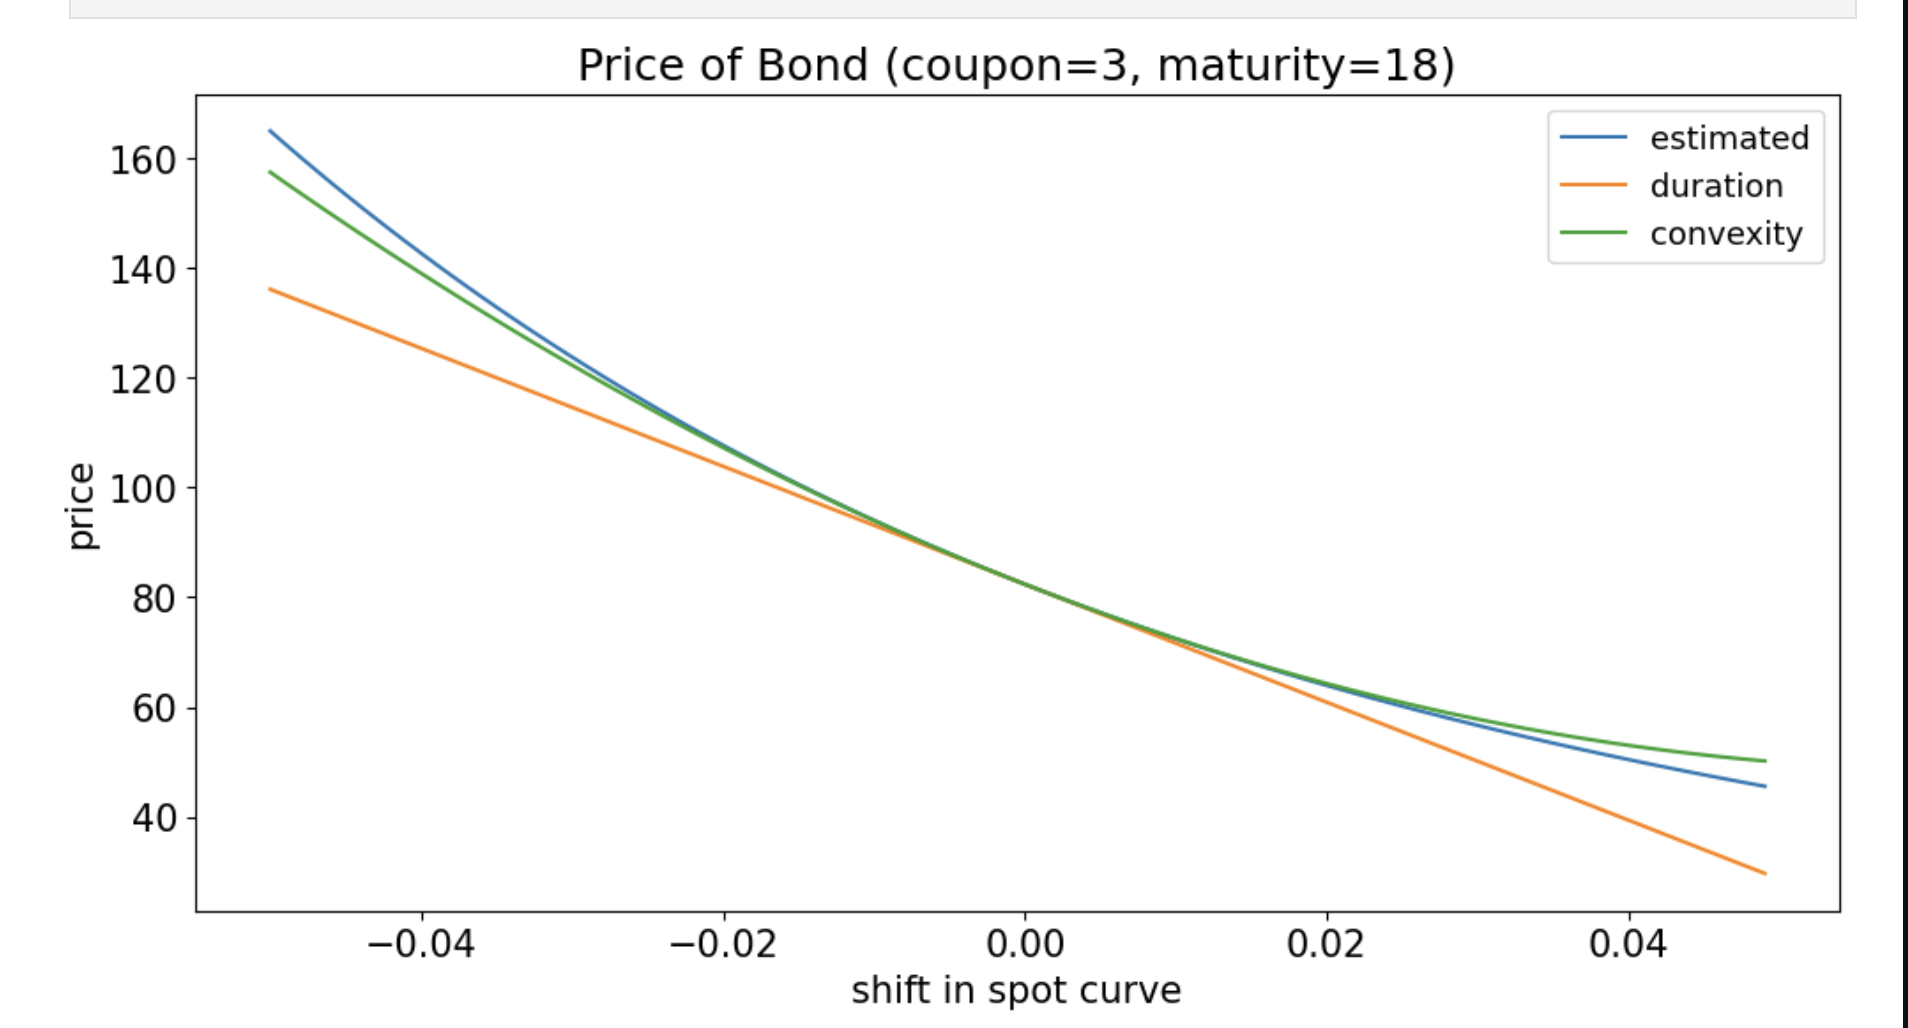

As you can see convexity allows us to get that curvature right when evaluating a change in the spot curve. 

### Revisiting the main idea of the 2008 Arbitrage Opportunity

#### What is the opportunity?

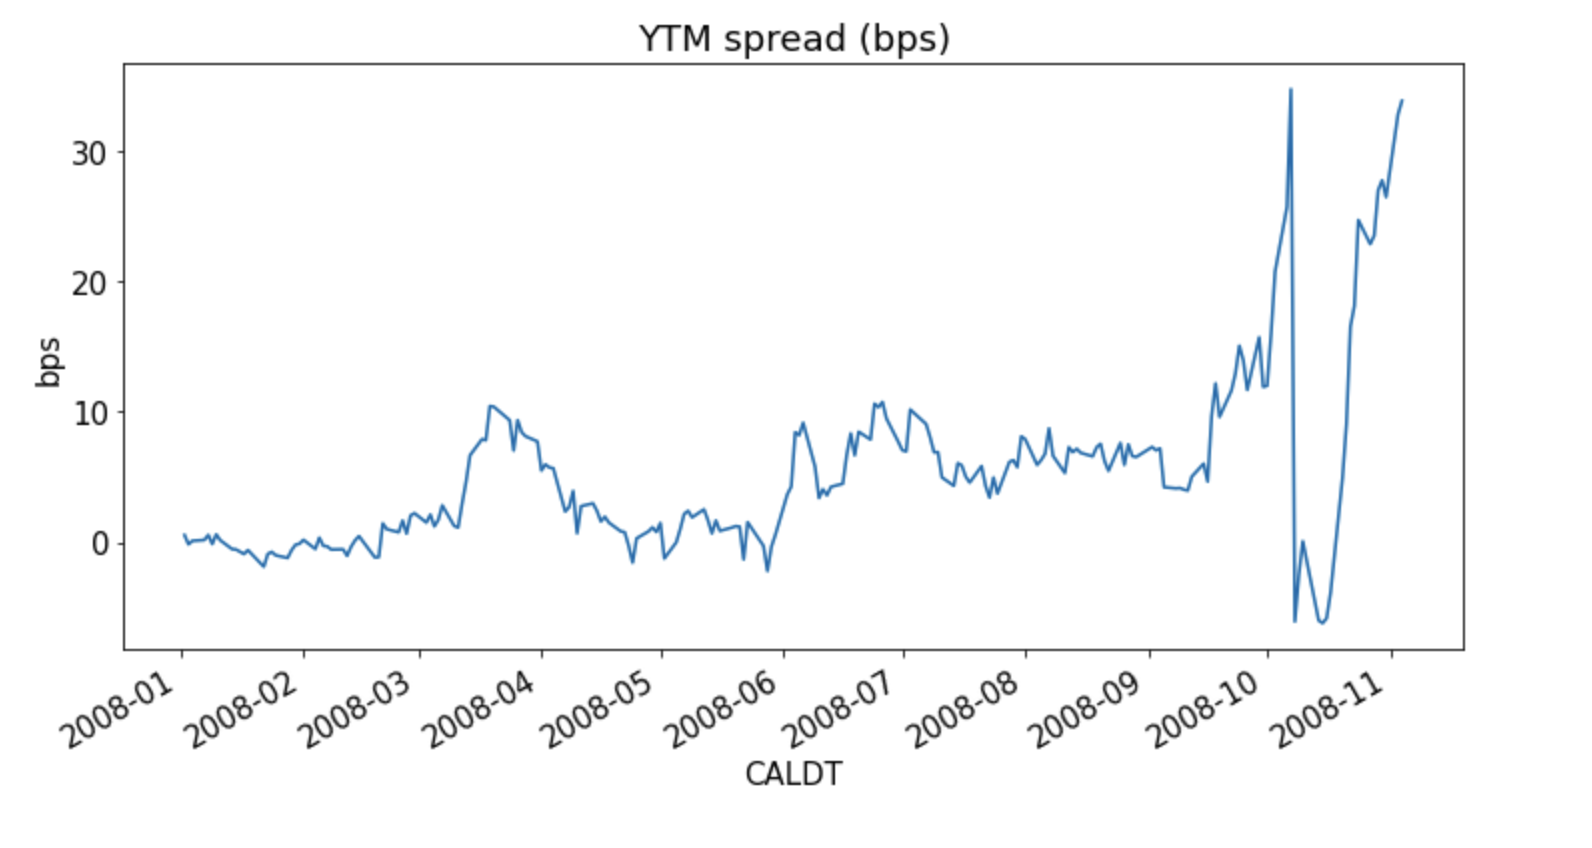

The opportunity here is that this spread has never been this large between a 30 year bond and a 10 year note. And it is bound to collapse at maturity, if not earlier. What can go wrong?

When trading opportunities like this always consider:
- Environment you are in: 2008, liquidity crisis in the financial sector
- Who are the players in this space? Treasury bond market makers who use large leverage in order to market make these bonds
- How much firepower do you have? In other words can you convince your boss/risk department to stay with you throughout the trade. 

You may not be operating in a fully functioning market. The market makers in this space might be the same troubled financial institutions, they may be unable to market make these markets efficiently hence why the spread went up like this. If that is the case shouldn't we be more cautius about this opportunity?

In [25]:
data = pd.ExcelFile("../data/treasury_ts_2015-08-15.xlsx")
database = data.parse("database", index_col = 0)
selected = database[(database["caldt"] == "2008-11-04")]
info = data.parse("info", index_col = 0, header = 1).transpose().drop(206524, axis = 0)

In [26]:
metrics = selected.copy()[['tdbid','tdask','tdaccint','tdduratn','tdyld']]
metrics.columns = ['bid','ask','accured interest','duration','ytm']
metrics["dirty price"] = 0.5*(metrics["bid"] + metrics["ask"]) + metrics["accured interest"]
metrics["coupon rate"] = info["tcouprt"]
metrics['duration'] /= 365.25
metrics['ytm'] *= 365
metrics["modified duration"] = (1 / (1 + metrics["ytm"]/2)) * metrics['duration']

#### Which bond should we long and which one should we short?

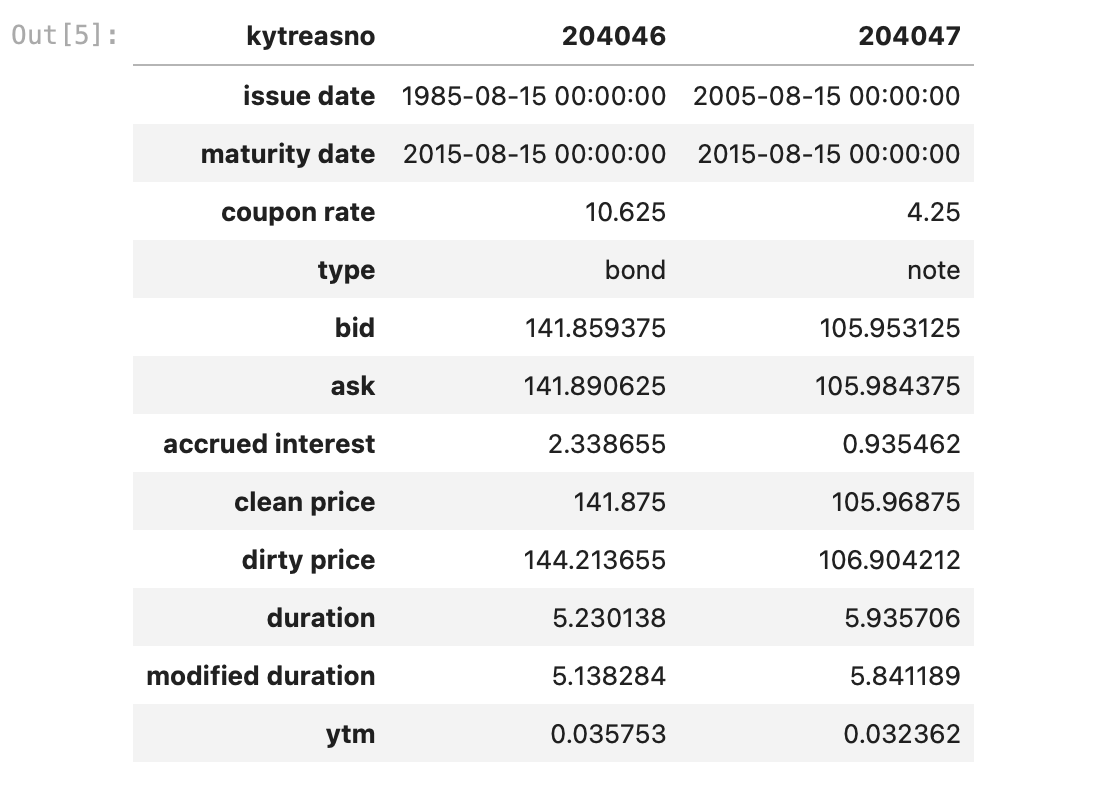

Main concept here is that we need a way to compare these two interest rate products on the same footing: 
- We cannot compare their dirty or clean prices necessarily because one is a bond and the other one is a note. 
- They have the same maturities but with different coupon rates and different current prices. 

YTM allows us to compare these bonds in a 'cashflow-neutral' way. The bond with higher YTM should be the one we go long and the one with lower YTM to short. 

#### How should we hedge them?

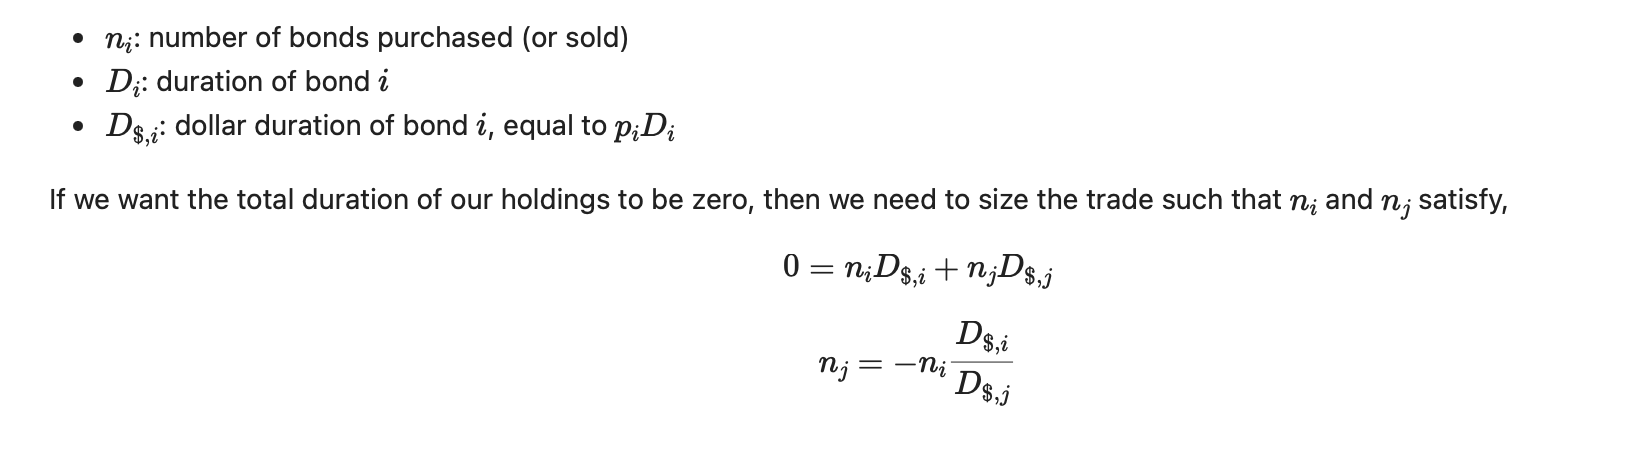

We will hedge them according to their dollar duration. Duration allows us to understand how much of a bond's price will move according to interest rate changes in the market place. In order to make sure we hedge the interest rate risk we need to make sure we allocate the right amount of dollar figure to each security. 

In [27]:
metrics["dollar duration"] = metrics["duration"] * metrics['dirty price']
valLong = 50000000
nlong = valLong / metrics.loc[204046,"dirty price"]
nshort = nlong * metrics.loc[204046,"dollar duration"] / metrics.loc[204047,'dollar duration'] 
valShort = nshort * metrics.loc[204047,"dirty price"]

In [28]:
theTrade = {"Bonds" : [204046,204047], "Contracts" : [nlong, nshort], "Leveraged Dollars": [valLong,-valShort]}
frame = pd.DataFrame.from_dict(theTrade).set_index("Bonds")

In [29]:
frame

,Contracts,Leveraged Dollars
Bonds,,
204046,346707.806814,5.000000e+07
204047,412112.657900,-4.405658e+07


#### Results

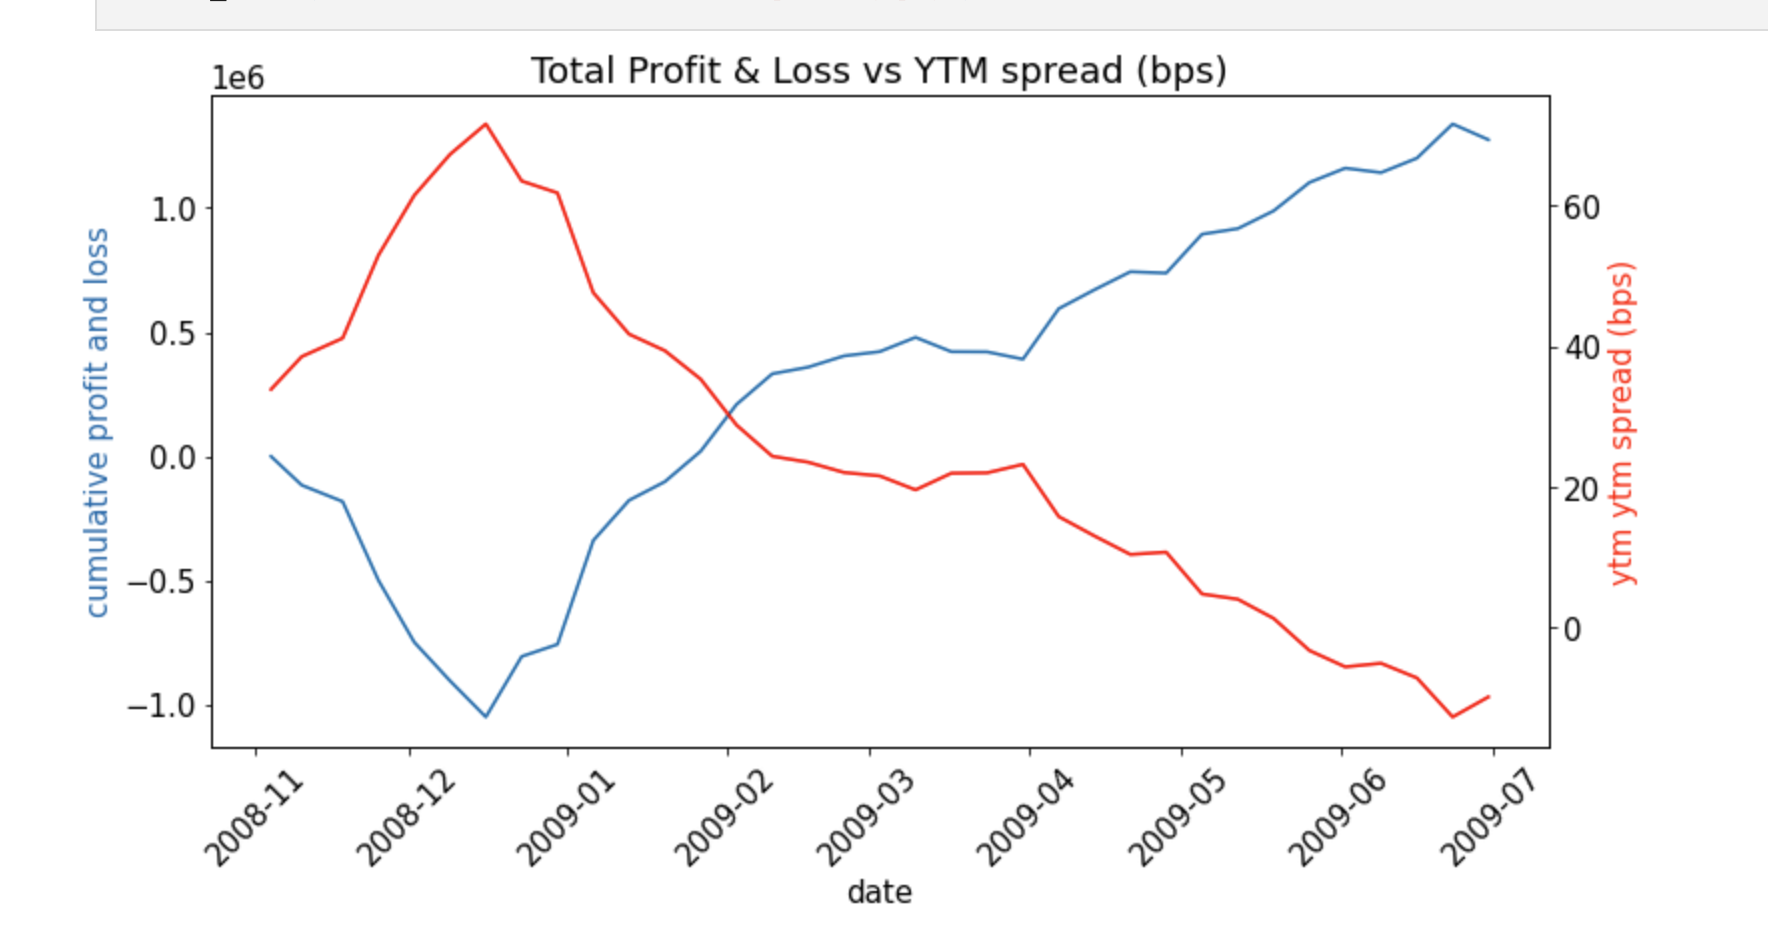

You would have to endure almost losing all of your equity before this thing starts to make money. Key factors here:
- Liquidity dries up in the financial crisis, which makes trading these bonds harder and harder.
- Illiquid markets and panic result in a wider ytm spread as these bonds trend in opposite directions.
- Once the panic subsides, and weaker players shaken out, market makers with liquidity come in to make these markets
- They see this trade and start closing the ytm and all is well again. 

Trading takeaways: 
- Know who your competitors and participants in your market
- Know your boss/risk manager's limits :) 
- Don't attempt trades that you can't complete

### Floating Rate Notes

#### Key Takeaways:
- Pays a coupon that is composed of a benchmark rate plus a spread. 
- Coupon payment is decided according to the value of the benchmark one payment cycle ago
- At each reset date the benchmark rate resets to it's current value
- Floating rate bonds will have a smaller duration than fixed rate bonds due to rates resetting
- The price of a floater without a spread at each reset date is equal to it's face value. 

#### Fixed vs Floating: Which one performs better?

 - Rising interest rates: Floating > Fixed
 - Falling interest rates: Fixed < Floating
 - Volatility: Floating < Fixed

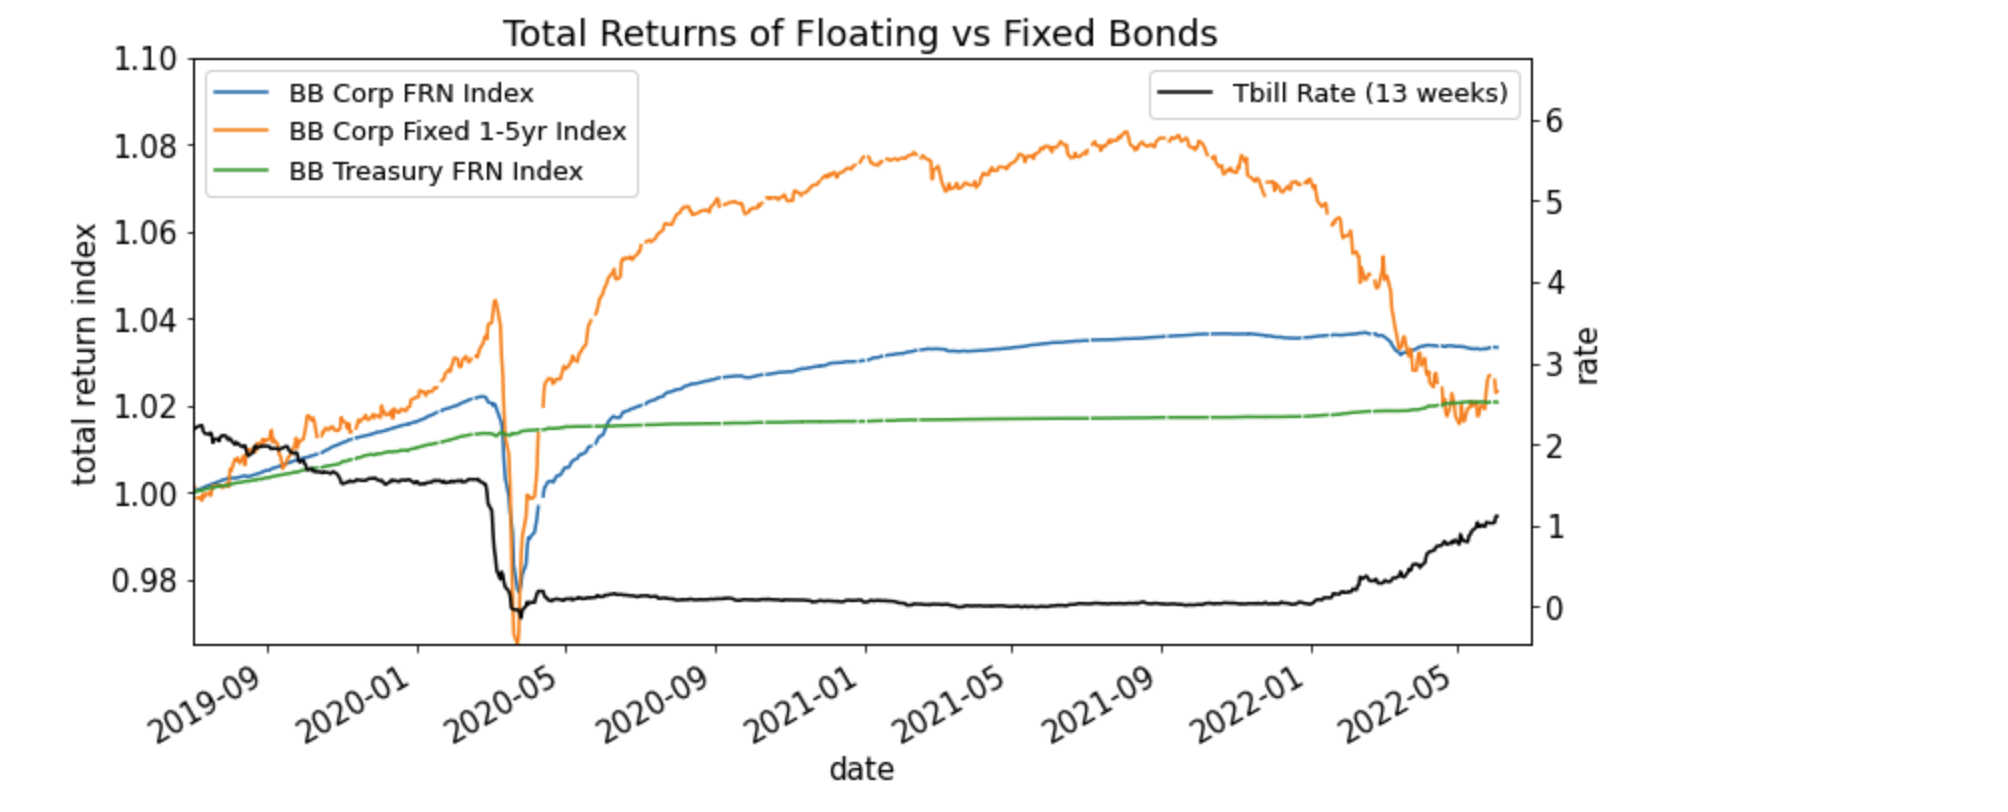